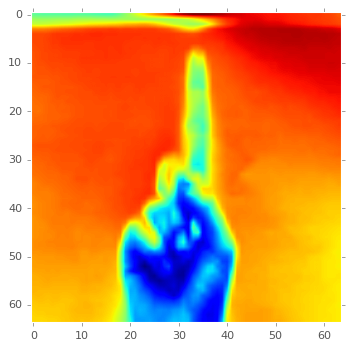

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

style.use("ggplot")

X = np.load("./archive/X.npy")
Y = np.load("./archive/Y.npy")

img_size = 64

plt.figure(figsize=(5, 5))
plt.imshow(X[1027].reshape(img_size, img_size))
plt.grid(0)

In [131]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, train_size=0.95)
train_size = X_train.shape[0]
test_size = X_test.shape[0]


In [132]:
from torch.utils.data import Dataset, DataLoader
from torch import transpose
import torch
from torchvision import transforms
from PIL import Image
from torch import nn

class DataProcessing(Dataset):
    def __init__(self, data, target, transform=None):
        self.transform = transform
        self.data = torch.from_numpy(data.reshape(-1, 64, 64).astype(np.float32))
        target_indices = np.argmax(target, axis=1)
        self.target = torch.from_numpy(target_indices)

        
    def __getitem__(self, index):
        return self.transform(self.data[index]), self.target[index]

    def __len__(self):
        return len(list(self.data))


In [133]:
transform = transforms.Compose([
    transforms.ToPILImage(), transforms.ToTensor()
])

dt_train = DataProcessing(X_train, Y_train, transform=transform)
dt_test = DataProcessing(X_test, Y_test, transform=transform)
train_loader = DataLoader(dt_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dt_test, batch_size=32, shuffle=False)

# plt.figure(figsize=(10, 10))
# np.random.seed(42)
# rnd = np.random.random_integers(0, 1200, 6)
# print(rnd)
# for num, x in enumerate(rnd):
#     plt.subplot(1, 6, num+1)
#     plt.imshow(X[x])
#     # plt.imshow(x)


In [134]:
class NNet(nn.Module):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2)
        )

        self.linear_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(32 * 32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = torch.flatten(x, start_dim=1)

        x = self.linear_layers(x)
        return torch.nn.functional.log_softmax(x, dim=1)


In [135]:

import torch.utils
import torch.utils.data


def train(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          criterion: torch.nn.Module):

    model.train()
    pred_sum_len = 0
    correct_pred_sum = 0

    for batch_idx, (X, y) in enumerate(train_loader):
        if torch.cuda.is_available():
            X = X.to("cuda")
            y = y.to("cuda")

        optimizer.zero_grad()
        model_output = model(X)

        _, y_pred = torch.max(model_output, 1)
        correct_pred_sum += (y_pred == y).sum()
        pred_sum_len += y.size(0)

        loss = criterion(model_output, y)

        loss.backward()
        optimizer.step()
        train_loss = loss.item()

        if (batch_idx + 1) % 100 == 0:
            torch.save(model.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

    lr_scheduler.step()
    
    t_loss = (train_loss / len(train_loader))
    t_acc = (correct_pred_sum * 100 / pred_sum_len)

    return t_loss, t_acc

In [136]:
def evaluate(model: torch.nn.Module,
             test_loader: torch.utils.data.DataLoader,
             criterion: torch.nn.Module):
    
    model.eval()
    lr_scheduler.step()
    pred_sum_len = 0
    correct_pred_sum = 0
    loss = 0

    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(test_loader):
            if torch.cuda.is_available():
                X = X.to("cuda")
                y = y.to("cuda")
            
            model_output = model(X)

            y_pred = torch.argmax(model_output, dim=1)
            
            loss += criterion(model_output, y).item()
            
            correct_pred_sum += (y_pred == y).sum().item()
            pred_sum_len += y.size(0)

    loss /= len(train_loader.dataset)
    valid_loss = loss
    valid_acc = correct_pred_sum * 100 / pred_sum_len
    
    return valid_loss, valid_acc

In [137]:
from tqdm.auto import tqdm

def train_model(model: torch.nn.Module,
          train_loader: torch.utils.data.DataLoader,
          test_loader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          criterion: torch.nn.Module,
          epochs: int = 5):
    
    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    for epoch in tqdm(range(epochs), desc="Training", position=0):
        
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        test_loss, test_acc = evaluate(model, test_loader, criterion)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [138]:
torch.manual_seed(42)

model = NNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)


if torch.cuda.is_available():
    model = model.cuda()
    cireterion = criterion.cuda()


NUM_EPOCHS = 30

model_results = train_model(model=model, train_loader=train_loader, test_loader=test_loader,
                            optimizer=optimizer, criterion=criterion, epochs=NUM_EPOCHS)


Training:   3%|▎         | 1/30 [00:17<08:35, 17.76s/it]

Epoch: 1 | train_loss: 0.0505 | train_acc: 61.6956 | test_loss: 0.0017 | test_acc: 75.0000


Training:   3%|▎         | 1/30 [00:22<10:57, 22.69s/it]


KeyboardInterrupt: 

In [ ]:
# checkpoint = {
#     'epoch': NUM_EPOCHS,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict()
#     }

# torch.save(checkpoint, "model_checkpoint.pth")
# torch.save(model_results, "model_results.pt")


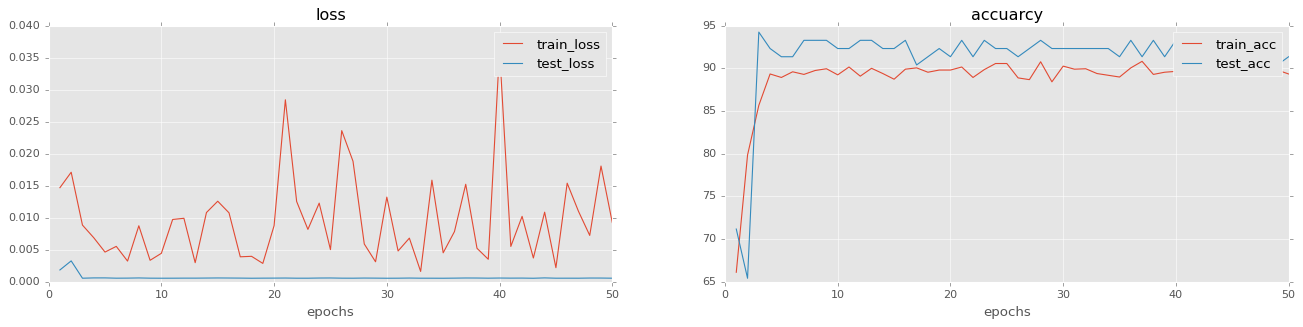

In [146]:
def plot_acc_loss(model_results):
    epochs = range(1, NUM_EPOCHS+1+20)
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, model_results["train_loss"], label='train_loss')
    plt.plot(epochs, model_results["test_loss"], label='test_loss')
    plt.xlabel("epochs")
    plt.title("loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, model_results["train_acc"], label='train_acc')
    plt.plot(epochs, model_results["test_acc"], label='test_acc')
    plt.xlabel("epochs")
    plt.title("accuarcy")
    plt.legend()

plot_acc_loss(model_results)

In [ ]:
def pred_prob():

    _, (val_data, val_target) = next(enumerate(test_loader))

    with torch.inference_mode():
        output = model(val_data)

    softmax = torch.exp(output)
    probs = list(softmax.numpy())
    probs

    plt.figure(figsize=(20, 8))
    # output.data.max(1,keepdim=True)[1]
    for i in range(4):
        plt.tight_layout()
        plt.subplot(4, 2, 2*i+1)
        # plt.style.use("classic")  
        plt.imshow(val_data[i][0])
        plt.xticks([])
        plt.yticks([])
        pred = output.data.max(1, keepdim=True)[1][i].item()
        plt.title(f"predicted sign: {pred}")
        plt.subplot(4, 2, 2*i+2)
        plt.barh([1], [max(probs[i])])
        plt.yticks([])
        plt.title(f"predicted probability: {max(probs[i]):.2f}")

In [139]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64),
    transforms.ToTensor()
])

train_data = DataProcessing(X_train, Y_train, transform=train_transform)
train_loader_transform = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)


model_results = train_model(model=model, train_loader=train_loader_transform, test_loader=test_loader,
                            optimizer=optimizer, criterion=criterion, epochs=NUM_EPOCHS+20)

checkpoint = {
    'epoch': NUM_EPOCHS+20,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    }

torch.save(checkpoint, "model_checkpoint2.pth")
torch.save(model_results, "model_results2.pt")

Training:   2%|▏         | 1/50 [00:17<14:39, 17.96s/it]

Epoch: 1 | train_loss: 0.0147 | train_acc: 66.0878 | test_loss: 0.0018 | test_acc: 71.1538


Training:   4%|▍         | 2/50 [00:35<14:06, 17.64s/it]

Epoch: 2 | train_loss: 0.0171 | train_acc: 79.8264 | test_loss: 0.0032 | test_acc: 65.3846


Training:   6%|▌         | 3/50 [00:53<13:52, 17.71s/it]

Epoch: 3 | train_loss: 0.0088 | train_acc: 85.6486 | test_loss: 0.0005 | test_acc: 94.2308


Training:   8%|▊         | 4/50 [01:12<14:01, 18.29s/it]

Epoch: 4 | train_loss: 0.0069 | train_acc: 89.3258 | test_loss: 0.0006 | test_acc: 92.3077


Training:  10%|█         | 5/50 [01:30<13:39, 18.21s/it]

Epoch: 5 | train_loss: 0.0046 | train_acc: 88.9173 | test_loss: 0.0006 | test_acc: 91.3462


Training:  12%|█▏        | 6/50 [01:49<13:36, 18.56s/it]

Epoch: 6 | train_loss: 0.0055 | train_acc: 89.5812 | test_loss: 0.0005 | test_acc: 91.3462


Training:  14%|█▍        | 7/50 [02:08<13:20, 18.62s/it]

Epoch: 7 | train_loss: 0.0032 | train_acc: 89.2748 | test_loss: 0.0005 | test_acc: 93.2692


Training:  16%|█▌        | 8/50 [02:27<13:11, 18.84s/it]

Epoch: 8 | train_loss: 0.0087 | train_acc: 89.7344 | test_loss: 0.0006 | test_acc: 93.2692


Training:  18%|█▊        | 9/50 [02:47<13:06, 19.17s/it]

Epoch: 9 | train_loss: 0.0033 | train_acc: 89.9387 | test_loss: 0.0005 | test_acc: 93.2692


Training:  20%|██        | 10/50 [03:07<12:56, 19.42s/it]

Epoch: 10 | train_loss: 0.0044 | train_acc: 89.2237 | test_loss: 0.0005 | test_acc: 92.3077


Training:  22%|██▏       | 11/50 [03:27<12:44, 19.61s/it]

Epoch: 11 | train_loss: 0.0097 | train_acc: 90.1430 | test_loss: 0.0005 | test_acc: 92.3077


Training:  24%|██▍       | 12/50 [03:47<12:23, 19.55s/it]

Epoch: 12 | train_loss: 0.0099 | train_acc: 89.0705 | test_loss: 0.0005 | test_acc: 93.2692


Training:  26%|██▌       | 13/50 [04:05<11:51, 19.22s/it]

Epoch: 13 | train_loss: 0.0029 | train_acc: 89.9898 | test_loss: 0.0005 | test_acc: 93.2692


Training:  28%|██▊       | 14/50 [04:24<11:33, 19.25s/it]

Epoch: 14 | train_loss: 0.0108 | train_acc: 89.3769 | test_loss: 0.0005 | test_acc: 92.3077


Training:  30%|███       | 15/50 [04:44<11:23, 19.52s/it]

Epoch: 15 | train_loss: 0.0126 | train_acc: 88.7130 | test_loss: 0.0006 | test_acc: 92.3077


Training:  32%|███▏      | 16/50 [05:05<11:15, 19.86s/it]

Epoch: 16 | train_loss: 0.0107 | train_acc: 89.8876 | test_loss: 0.0006 | test_acc: 93.2692


Training:  34%|███▍      | 17/50 [05:26<11:03, 20.10s/it]

Epoch: 17 | train_loss: 0.0039 | train_acc: 90.0409 | test_loss: 0.0005 | test_acc: 90.3846


Training:  36%|███▌      | 18/50 [05:46<10:43, 20.11s/it]

Epoch: 18 | train_loss: 0.0039 | train_acc: 89.5301 | test_loss: 0.0005 | test_acc: 91.3462


Training:  38%|███▊      | 19/50 [06:09<10:49, 20.94s/it]

Epoch: 19 | train_loss: 0.0028 | train_acc: 89.7855 | test_loss: 0.0005 | test_acc: 92.3077


Training:  40%|████      | 20/50 [06:30<10:29, 20.98s/it]

Epoch: 20 | train_loss: 0.0087 | train_acc: 89.7855 | test_loss: 0.0005 | test_acc: 91.3462


Training:  42%|████▏     | 21/50 [06:51<10:11, 21.08s/it]

Epoch: 21 | train_loss: 0.0284 | train_acc: 90.1430 | test_loss: 0.0005 | test_acc: 93.2692


Training:  44%|████▍     | 22/50 [07:12<09:46, 20.94s/it]

Epoch: 22 | train_loss: 0.0125 | train_acc: 88.9173 | test_loss: 0.0005 | test_acc: 91.3462


Training:  46%|████▌     | 23/50 [07:32<09:22, 20.84s/it]

Epoch: 23 | train_loss: 0.0082 | train_acc: 89.8366 | test_loss: 0.0005 | test_acc: 93.2692


Training:  48%|████▊     | 24/50 [07:57<09:30, 21.92s/it]

Epoch: 24 | train_loss: 0.0123 | train_acc: 90.5516 | test_loss: 0.0006 | test_acc: 92.3077


Training:  50%|█████     | 25/50 [08:20<09:14, 22.17s/it]

Epoch: 25 | train_loss: 0.0050 | train_acc: 90.5516 | test_loss: 0.0006 | test_acc: 92.3077


Training:  52%|█████▏    | 26/50 [08:43<08:57, 22.41s/it]

Epoch: 26 | train_loss: 0.0236 | train_acc: 88.8662 | test_loss: 0.0005 | test_acc: 91.3462


Training:  54%|█████▍    | 27/50 [09:03<08:23, 21.88s/it]

Epoch: 27 | train_loss: 0.0188 | train_acc: 88.6619 | test_loss: 0.0005 | test_acc: 92.3077


Training:  56%|█████▌    | 28/50 [09:25<07:58, 21.76s/it]

Epoch: 28 | train_loss: 0.0059 | train_acc: 90.7559 | test_loss: 0.0005 | test_acc: 93.2692


Training:  58%|█████▊    | 29/50 [09:46<07:32, 21.53s/it]

Epoch: 29 | train_loss: 0.0031 | train_acc: 88.4065 | test_loss: 0.0005 | test_acc: 92.3077


Training:  60%|██████    | 30/50 [10:07<07:08, 21.44s/it]

Epoch: 30 | train_loss: 0.0132 | train_acc: 90.2451 | test_loss: 0.0005 | test_acc: 92.3077


Training:  62%|██████▏   | 31/50 [10:28<06:46, 21.40s/it]

Epoch: 31 | train_loss: 0.0048 | train_acc: 89.8876 | test_loss: 0.0005 | test_acc: 92.3077


Training:  64%|██████▍   | 32/50 [10:48<06:14, 20.80s/it]

Epoch: 32 | train_loss: 0.0068 | train_acc: 89.9387 | test_loss: 0.0005 | test_acc: 92.3077


Training:  66%|██████▌   | 33/50 [11:11<06:05, 21.49s/it]

Epoch: 33 | train_loss: 0.0016 | train_acc: 89.3769 | test_loss: 0.0005 | test_acc: 92.3077


Training:  68%|██████▊   | 34/50 [11:33<05:48, 21.77s/it]

Epoch: 34 | train_loss: 0.0158 | train_acc: 89.1726 | test_loss: 0.0005 | test_acc: 92.3077


Training:  70%|███████   | 35/50 [11:54<05:24, 21.65s/it]

Epoch: 35 | train_loss: 0.0045 | train_acc: 88.9683 | test_loss: 0.0005 | test_acc: 91.3462


Training:  72%|███████▏  | 36/50 [12:16<05:03, 21.71s/it]

Epoch: 36 | train_loss: 0.0078 | train_acc: 90.0409 | test_loss: 0.0005 | test_acc: 93.2692


Training:  74%|███████▍  | 37/50 [12:38<04:43, 21.80s/it]

Epoch: 37 | train_loss: 0.0152 | train_acc: 90.8069 | test_loss: 0.0006 | test_acc: 91.3462


Training:  76%|███████▌  | 38/50 [12:58<04:14, 21.24s/it]

Epoch: 38 | train_loss: 0.0052 | train_acc: 89.2748 | test_loss: 0.0006 | test_acc: 93.2692


Training:  78%|███████▊  | 39/50 [13:17<03:46, 20.56s/it]

Epoch: 39 | train_loss: 0.0035 | train_acc: 89.5301 | test_loss: 0.0005 | test_acc: 91.3462


Training:  80%|████████  | 40/50 [13:36<03:20, 20.07s/it]

Epoch: 40 | train_loss: 0.0362 | train_acc: 89.6323 | test_loss: 0.0006 | test_acc: 93.2692


Training:  82%|████████▏ | 41/50 [13:57<03:02, 20.32s/it]

Epoch: 41 | train_loss: 0.0055 | train_acc: 90.1430 | test_loss: 0.0005 | test_acc: 91.3462


Training:  84%|████████▍ | 42/50 [14:19<02:46, 20.78s/it]

Epoch: 42 | train_loss: 0.0102 | train_acc: 90.7048 | test_loss: 0.0005 | test_acc: 92.3077


Training:  86%|████████▌ | 43/50 [14:39<02:24, 20.67s/it]

Epoch: 43 | train_loss: 0.0037 | train_acc: 90.6027 | test_loss: 0.0005 | test_acc: 91.3462


Training:  88%|████████▊ | 44/50 [15:01<02:06, 21.01s/it]

Epoch: 44 | train_loss: 0.0108 | train_acc: 89.7855 | test_loss: 0.0006 | test_acc: 91.3462


Training:  90%|█████████ | 45/50 [15:23<01:47, 21.41s/it]

Epoch: 45 | train_loss: 0.0022 | train_acc: 90.3984 | test_loss: 0.0005 | test_acc: 92.3077


Training:  92%|█████████▏| 46/50 [15:45<01:26, 21.51s/it]

Epoch: 46 | train_loss: 0.0154 | train_acc: 89.5812 | test_loss: 0.0005 | test_acc: 92.3077


Training:  94%|█████████▍| 47/50 [16:06<01:04, 21.43s/it]

Epoch: 47 | train_loss: 0.0110 | train_acc: 90.2962 | test_loss: 0.0005 | test_acc: 92.3077


Training:  96%|█████████▌| 48/50 [16:28<00:42, 21.43s/it]

Epoch: 48 | train_loss: 0.0072 | train_acc: 89.6323 | test_loss: 0.0005 | test_acc: 92.3077


Training:  98%|█████████▊| 49/50 [16:49<00:21, 21.38s/it]

Epoch: 49 | train_loss: 0.0180 | train_acc: 89.7855 | test_loss: 0.0005 | test_acc: 90.3846


Training: 100%|██████████| 50/50 [17:09<00:00, 20.59s/it]

Epoch: 50 | train_loss: 0.0092 | train_acc: 89.3258 | test_loss: 0.0005 | test_acc: 91.3462


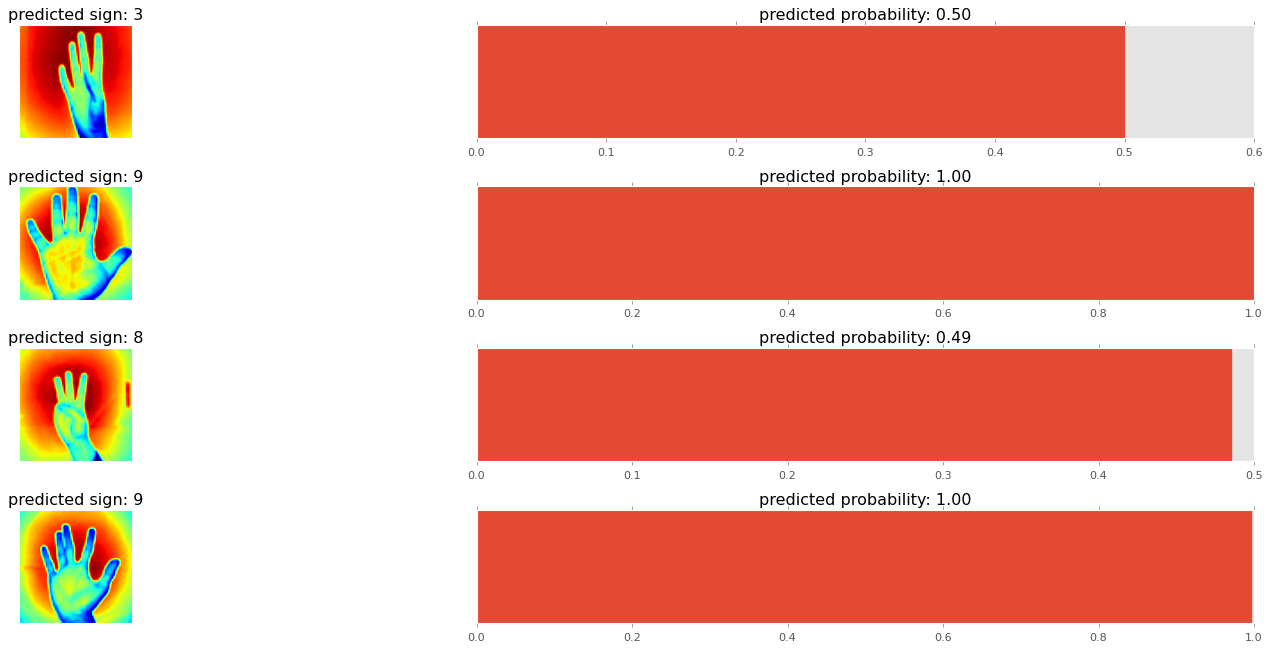

In [144]:
pred_prob()

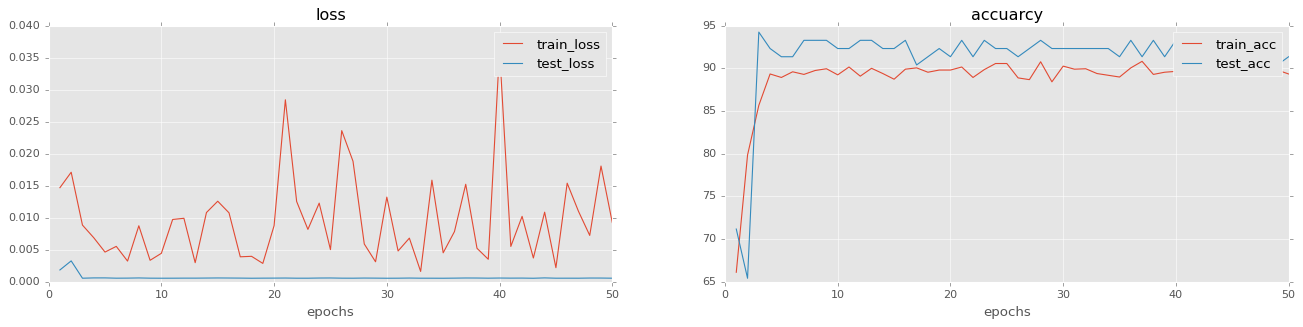

In [147]:
plot_acc_loss(model_results)